In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
dataset_path = './PlantVillage'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes

In [4]:
class PlantDiseaseModel(nn.Module):
    def __init__(self, num_classes=3, init_image_size=256):
        super(PlantDiseaseModel, self).__init__()
        self.init_image_size = init_image_size 
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        feature_size = self.init_image_size // (2 ** 6)  
        linear_input_features = 64 * (feature_size ** 2)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linear_input_features, 64),  
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [5]:
checkpoint_file = 'model_checkpoint_final.pth'
checkpoint = torch.load(checkpoint_file)

model = PlantDiseaseModel(num_classes=10)
model.load_state_dict(checkpoint['model_state_dict'])

for name, param in model.named_parameters():
    print(f'Parameter name: {name}')
    print(f'Parameter value: {param}')

Parameter name: features.0.weight
Parameter value: Parameter containing:
tensor([[[[ 0.3408,  0.1648,  0.1709],
          [-0.0505,  0.2006,  0.0605],
          [ 0.2035,  0.2900,  0.0357]],

         [[-0.1619, -0.1265,  0.0142],
          [ 0.0797, -0.0880,  0.1307],
          [-0.1595, -0.0487, -0.0417]],

         [[-0.1811,  0.0665, -0.0614],
          [ 0.0721,  0.0974, -0.0217],
          [ 0.0455, -0.1071,  0.1082]]],


        [[[ 0.1802,  0.2020,  0.1175],
          [-0.2338,  0.2597, -0.0818],
          [-0.0786,  0.2205, -0.0040]],

         [[-0.1593,  0.1231, -0.0243],
          [-0.3511, -0.1062,  0.0134],
          [-0.2345, -0.1229,  0.1455]],

         [[ 0.1687,  0.0532, -0.0135],
          [-0.1008,  0.0979,  0.0440],
          [-0.0161,  0.0086, -0.1312]]],


        [[[-0.0926,  0.0086, -0.0635],
          [-0.1994, -0.1476, -0.0790],
          [-0.2395, -0.0261, -0.2121]],

         [[-0.0936,  0.1384,  0.0060],
          [ 0.0426,  0.1081, -0.0702],
          [ 

In [6]:
test_loss = checkpoint['epoch_loss']
accuracy = checkpoint['epoch_acc']

# Print epoch_loss and epoch_acc
print("Epoch Loss:", test_loss)
print("Epoch Accuracy:", accuracy)

Epoch Loss: 0.07929374090813593
Epoch Accuracy: 97.62796504369538


In [7]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [8]:
def predict_pytorch(model, img, class_names, transform):

    img_transformed = transform(img).unsqueeze(0)

    device = next(model.parameters()).device
    img_transformed = img_transformed.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_transformed)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        predicted_class = class_names[predicted.item()]
        confidence = round(100 * confidence.item(), 2)

    return predicted_class, confidence

In [9]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
model.eval()
model.to(device)

upload = widgets.FileUpload()
button = widgets.Button(description="Predict")
output = widgets.Output()

def on_button_clicked(b):

    with output:
        clear_output()
        if upload.value:
            input_image = upload.value[0]
            content = input_image['content']
            img = Image.open(io.BytesIO(content))
            
            display(img)
            
            predicted_class, confidence = predict_pytorch(model, img, class_names, transform)
            
            print(f"Predicted Class: {predicted_class}, Confidence: {confidence}%")
            
        else:
            print("No image uploaded. Please upload an image of a diseased plant leaf.")
            

button.on_click(on_button_clicked)
display(upload, button, output)


FileUpload(value=(), description='Upload')

Button(description='Predict', style=ButtonStyle())

Output()

In [ ]:
'''
Since opening this notebook in github doesn't show the upload and predict button
Therefore, I have printed the output object separately
When you will download the notebook on your local PC, 
then these buttons will be visible, and you will be able to use them

I uploaded the Tomato_Bacterial_spot leaf taken from the internet & the model predicted the following:
Predicted Class: Tomato_Bacterial_spot, Confidence: 99.94%
'''
output

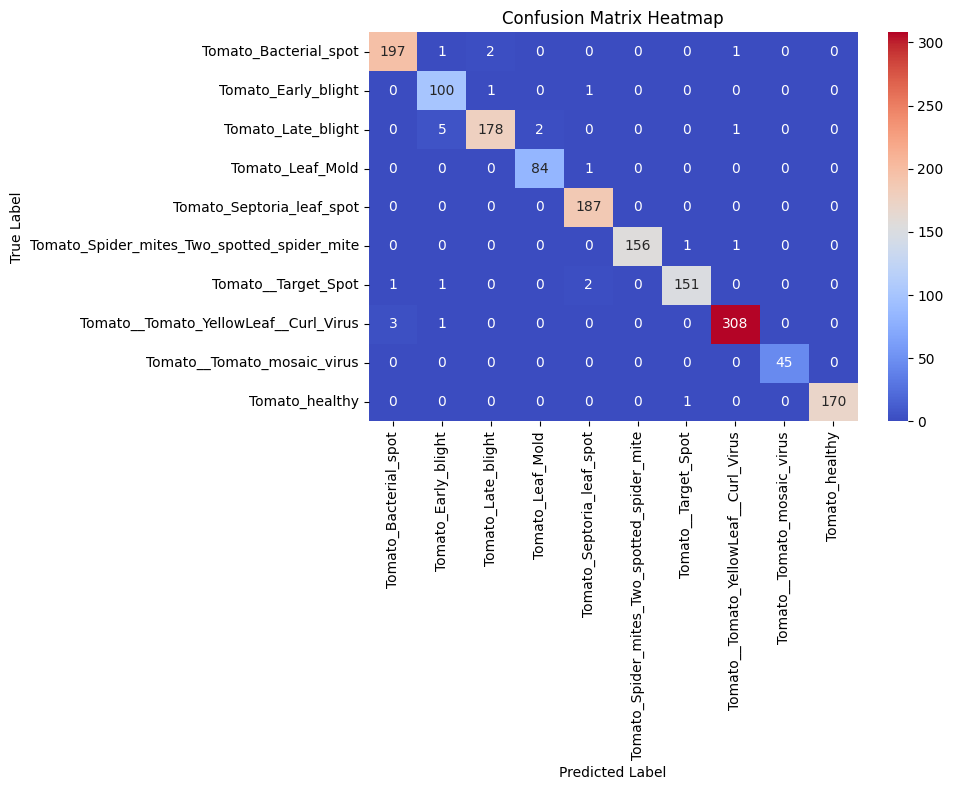

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

plt.tight_layout()
plt.savefig('confusion_matrix_heatmap.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()